### This is a demo for dem generation by using aster stereo images.
#### We use asp tool to perform dem generation with mapprojected aster images (Auxiliary low-resolution dem data is required)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.lay_stack import lay_stack
from utils.imgShow import imgShow
from utils.get_dem import get_dem
from zipfile import ZipFile


#### Parameters settings

In [4]:
output_res = 30  # m resolution for output DEM
tsrs_wgs84 = '+proj=longlat +datum=WGS84' # UTM projection 
setting = 'script/stereo.default'
dir_data='data/aster-stereo/demo'
aster_raw_l1a = dir_data + '/AST_L1A_00302072020041614_20221005163439_13049'
zip = ZipFile(aster_raw_l1a + '.zip')   ## unzip the raw data
zip.extractall(aster_raw_l1a)


### 1. Parse the aster data

In [5]:
!aster2asp $aster_raw_l1a -o $dir_data/aster-parse/VNIR


	--> Setting number of processing threads to: 4

Creating output directory: "data/aster-stereo/demo/aster-parse".
Writing: data/aster-stereo/demo/aster-parse/VNIR-Band3N.xml
Writing: data/aster-stereo/demo/aster-parse/VNIR-Band3B.xml
Writing: data/aster-stereo/demo/aster-parse/VNIR-Band3N.tif
        -->: [*******************************************************] Complete!
Writing: data/aster-stereo/demo/aster-parse/VNIR-Band3B.tif
        -->: [*******************************************************] Complete!


### 2. Get the location and utm projection information of the corresponding region.

In [6]:
## project the aster to wgs84 and calculate the utm zone
!mapproject -t rpc --t_srs "$tsrs_wgs84" WGS84 $dir_data/aster-parse/VNIR-Band3N.tif $dir_data/aster-parse/VNIR-Band3N.xml $dir_data/aster-reproj/VNIR_Band3N_wgs84.tif
aster_Band3N, aster_Band3N_info = readTiff(dir_data+'/aster-reproj/VNIR_Band3N_wgs84.tif')
print('aster_Band3N_info:', aster_Band3N_info)
aoi_extent = list(aster_Band3N_info['geoextent'])
if aoi_extent[0] > 180: aoi_extent[0] = aoi_extent[0] - 360   ### longitude offset 360
if aoi_extent[1] > 180: aoi_extent[1] = aoi_extent[1] - 360
print('aoi_extent:', aoi_extent)
utm_zone = int((aoi_extent[0]/2+aoi_extent[1]/2)/6 + 31)
tsrs_utm = '+proj=utm +zone=' + str(utm_zone) + ' +ellps=WGS84 +datum=WGS84 +units=m +no_defs' # UTM projection 
print('tsrs_utm:', tsrs_utm)


mapproject_single --query-projection WGS84 data/aster-stereo/demo/aster-parse/VNIR-Band3N.tif data/aster-stereo/demo/aster-parse/VNIR-Band3N.xml data/aster-stereo/demo/aster-reproj/VNIR_Band3N_wgs84.tif -t rpc --t_srs +proj=longlat +datum=WGS84
	--> Setting number of processing threads to: 4
Using session: rpc
Loading camera model: data/aster-stereo/demo/aster-parse/VNIR-Band3N.tif data/aster-stereo/demo/aster-parse/VNIR-Band3N.xml
	--> Using flat datum "WGS84" as elevation model.
Output pixel size: 0.000146863
Projected space bounding box: (Origin: (98.650310118886409, 28.365982695424464) width: 0.78703830917947926 height: 0.65280561379040591)
Image box: (Origin: (0, 0) width: 5360 height: 4446)
Output image size:
(width: 5360 height: 4446)
Query finished, exiting mapproject tool.

Output image size is 5360 by 4446 pixels.
Splitting into 2 by 1 tiles.
parallel --will-cite --workdir /home/xin/Developer-luo/Glacier-in-SETP -u --env PATH --env PYTHONPATH --env ISISROOT --env ASP_LIBRARY_

### 3. Get the srtm dem data of the region

In [7]:
## Note: !!!should login the OpenTopography firstly. 
path_srtm_wgs84 = 'data/aster-stereo/demo/srtm_wgs84.tif'
get_dem('SRTMGL1_E', aoi_extent, '7f97d1b49489d7c0e346b085772aef3c', path_out=path_srtm_wgs84)


!!Output file has been existed.


##### Reproject to utm for the srtm dem data

In [8]:
path_srtm_wgs84 = 'data/aster-stereo/demo/srtm_wgs84.tif'
path_srtm_utm = 'data/aster-stereo/demo/srtm_utm.tif'
!gdalwarp -overwrite -s_srs EPSG:4326 -t_srs "$tsrs_utm" -tr 30 30 -r cubic -co COMPRESS=LZW -co TILED=YES $path_srtm_wgs84 $path_srtm_utm


Creating output file that is 2571P x 2414L.
Processing data/aster-stereo/demo/srtm_wgs84.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image data/aster-stereo/demo/srtm_wgs84.tif.
Copying nodata values from source data/aster-stereo/demo/srtm_wgs84.tif to destination data/aster-stereo/demo/srtm_utm.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


{'geoextent': (465717.5732634025, 542847.5732634026, 3137752.591853475, 3210172.591853475), 'geotrans': (465717.5732634025, 30.0, 0.0, 3210172.591853475, 0.0, -30.0), 'geosrs': '32647', 'row': 2414, 'col': 2571, 'bands': 1}


Text(0.5, 1.0, 'SRTM_DEM data')

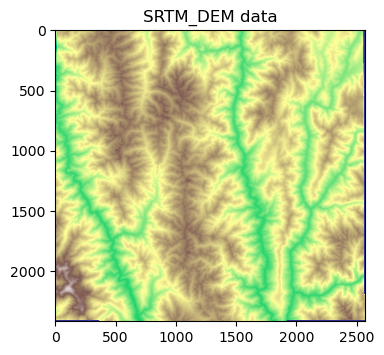

In [9]:
plt.figure(figsize=(4,4))
srtm_utm, srtm_utm_info = readTiff(path_srtm_utm)
print(srtm_utm_info)
plt.imshow(srtm_utm,vmin=0, vmax=7000, cmap='terrain')
plt.title('SRTM_DEM data')


In [10]:
### re-projected the l1a VNIR bands to utm (15 m, bands of green, red, nir-B, nir-N)
!mapproject -t rpc --tr 30 --t_srs "$tsrs_utm" $path_srtm_utm $dir_data/aster-parse/VNIR-Band3N.tif $dir_data/aster-parse/VNIR-Band3N.xml $dir_data/aster-reproj/VNIR_Band3N_utm.tif
!mapproject -t rpc --tr 30 --t_srs "$tsrs_utm" $path_srtm_utm $dir_data/aster-parse/VNIR-Band3B.tif $dir_data/aster-parse/VNIR-Band3B.xml $dir_data/aster-reproj/VNIR_Band3B_utm.tif
!mapproject -t rpc --tr 30 --t_srs "$tsrs_utm" $path_srtm_utm $aster_raw_l1a/*VNIR_Band1*.tif $dir_data/aster-parse/VNIR-Band3N.xml $dir_data/aster-reproj/VNIR_Band1_utm.tif
!mapproject -t rpc --tr 30 --t_srs "$tsrs_utm" $path_srtm_utm $aster_raw_l1a/*VNIR_Band2*.tif $dir_data/aster-parse/VNIR-Band3N.xml $dir_data/aster-reproj/VNIR_Band2_utm.tif


mapproject_single --query-projection data/aster-stereo/demo/srtm_utm.tif data/aster-stereo/demo/aster-parse/VNIR-Band3N.tif data/aster-stereo/demo/aster-parse/VNIR-Band3N.xml data/aster-stereo/demo/aster-reproj/VNIR_Band3N_utm.tif -t rpc --tr 30 --t_srs +proj=utm +zone=47 +ellps=WGS84 +datum=WGS84 +units=m +no_defs
	--> Setting number of processing threads to: 4
Using session: rpc
Loading camera model: data/aster-stereo/demo/aster-parse/VNIR-Band3N.tif data/aster-stereo/demo/aster-parse/VNIR-Band3N.xml
Output pixel size: 30
Projected space bounding box: (Origin: (465750, 3137880) width: 76170 height: 72210)
Image box: (Origin: (0, 0) width: 2540 height: 2408)
Output image size:
(width: 2540 height: 2408)
Query finished, exiting mapproject tool.

Output image size is 2540 by 2408 pixels.
Splitting into 1 by 1 tiles.
parallel --will-cite --workdir /home/xin/Developer-luo/Glacier-in-SETP -u --env PATH --env PYTHONPATH --env ISISROOT --env ASP_LIBRARY_PATH --env ISISDATA -a data/aster-ster

### 4. Generate point cloud data

In [11]:
path_srtm_utm = 'data/aster-stereo/demo/srtm_utm.tif'

# ### !!note: the more parameters should be set in the stereo.default file.
!parallel_stereo -t astermaprpc \
                      --alignment-method none \
                      --stereo-algorithm 1 \
                      --cost-mode 4 \
                      --subpixel-mode 3 \
                      --skip-rough-homography \
                      $dir_data/aster-reproj/VNIR_Band3N_utm.tif $dir_data/aster-reproj/VNIR_Band3B_utm.tif \
                      $dir_data/aster-parse/VNIR-Band3N.xml $dir_data/aster-parse/VNIR-Band3B.xml \
                      $dir_data/pc-utm-out/run $path_srtm_utm


Using tiles (before collar addition) of 1024 x 1024 pixels.
Using a collar (padding) for each tile of 512 pixels.

[ 2022-Nov-17 14:32:36 ] : Stage 0 --> PREPROCESSING 
	--> Setting number of processing threads to: 36
Stereo file ./stereo.default could not be found. Will use default settings and command line options only.
Writing log info to: data/aster-stereo/demo/pc-utm-out/run-log-stereo_pprc-11-17-1432-5068.txt
Will refine the disparity using the ASP subpixel-mode: 3.
Using session: astermaprpc
Loading camera model: data/aster-stereo/demo/aster-reproj/VNIR_Band3N_utm.tif data/aster-stereo/demo/aster-parse/VNIR-Band3N.xml
Loading camera model: data/aster-stereo/demo/aster-reproj/VNIR_Band3B_utm.tif data/aster-stereo/demo/aster-parse/VNIR-Band3B.xml
Distance between camera centers in meters: 411262.
Using image files:  data/aster-stereo/demo/aster-reproj/VNIR_Band3N_utm.tif, data/aster-stereo/demo/aster-reproj/VNIR_Band3B_utm.tif
Using camera files: data/aster-stereo/demo/aster-parse

### convert point cloud data to dem

In [14]:
!point2dem --tr $output_res --t_srs "$tsrs_utm" --errorimage $dir_data/pc-utm-out/run-PC.tif -o $dir_data/dem-utm-out/run



	--> Setting number of processing threads to: 4

Creating output directory: "data/aster-stereo/demo/dem-utm-out".
Writing log info to: data/aster-stereo/demo/dem-utm-out/run-log-point2dem-11-17-1436-6284.txt
Statistics: [********************************************************] Complete!
Bounding box and triangulation error range estimation: [*************] Complete!
QuadTree: [**********************************************************] Complete!
Collected a sample of 4120331 positive triangulation errors.
Error percentiles: Q1 (25%): 4.37819, Q2 (50%): 7.05375, Q3 (75%): 10.3374.
Computing triangulation error cutoff based on --remove-outliers-params.
Triangulation error cutoff is 31.0122 meters.
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2458,2329) px.
Writing: data/aster-stereo/demo/dem-utm-out/run-DEM.tif
DEM: [***************************************************************] Complete!
Percentage

### Visualize results.

In [15]:
### Layer stacking of the VNIR bands.
Band1 = dir_data + '/aster-reproj/VNIR_Band1_utm.tif'
Band2 = dir_data + '/aster-reproj/VNIR_Band2_utm.tif' 
Band3N = dir_data + '/aster-reproj/VNIR_Band3N_utm.tif' 
path_laysta = dir_data + '/aster-reproj/VNIR_LayStack_utm.tif'
lay_stack(path_imgs=[Band1, Band2, Band3N], path_out=path_laysta, union=True)


Images layer stacking done.


Text(0.5, 1.0, 'SRTM DEM')

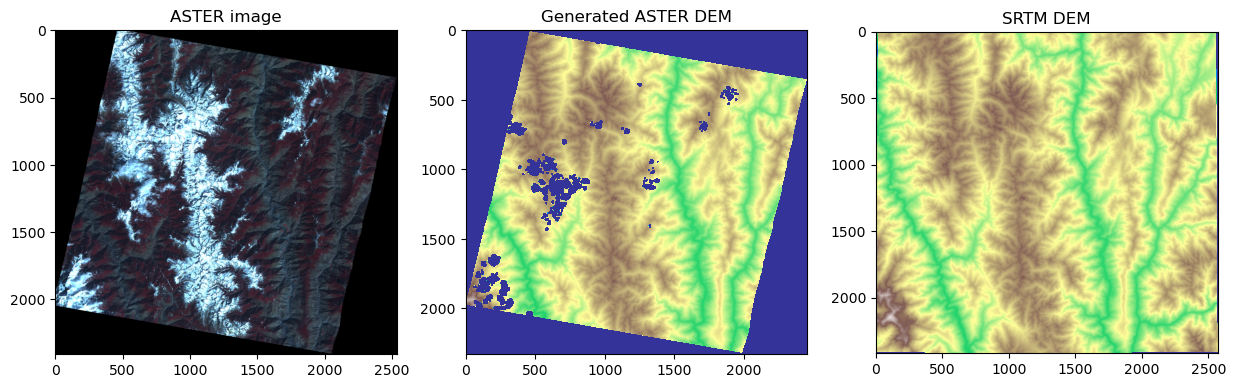

In [16]:
path_laysta_utm = dir_data + '/aster-reproj/VNIR_LayStack_utm.tif'
path_dem_aster_utm = dir_data + '/dem-utm-out/run-DEM.tif'
path_srtm_utm = 'data/aster-stereo/demo/srtm_utm.tif'
dem_aster_utm, dem_aster_utm_info = readTiff(path_dem_aster_utm)
dem_srtm_utm, dem_srtm_utm_info = readTiff(path_srtm_utm)
aster_vnir, aster_vnir_info = readTiff(path_laysta_utm)
aster_vnir[aster_vnir==-32768]=0
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1); 
imgShow(aster_vnir, color_bands=[2,1,0], clip_percent=5)
plt.title('ASTER image')
plt.subplot(1, 3, 2); 
plt.imshow(dem_aster_utm, vmin=0, vmax=7000, cmap='terrain')
plt.title('Generated ASTER DEM')
plt.subplot(1, 3, 3); 
plt.imshow(dem_srtm_utm, vmin=0, vmax=7000, cmap='terrain')
plt.title('SRTM DEM')
